In [11]:
import sys
from pathlib import Path
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
from src.utils.paths import load_paths
paths = load_paths()


## Importing the 2 JSON files and paths

In [12]:
import pandas as pd
import json
import os
from PIL import Image
import sys
import bioclip
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Load your prepared data
DATA_PATH = paths['processed_dir'] / 'final_data_no_ixodes.json'
CLASS_NAMES_PATH = paths['processed_dir'] / 'class_names_no_ixodes.json'

with open(DATA_PATH, 'r') as f:
    image_data = json.load(f)

with open(CLASS_NAMES_PATH, 'r') as f:
    class_names = json.load(f)

print(f"First few entries in the data:", image_data[:5])
print(f"Printing the class names:", class_names[:7])

print(f"Loaded {len(image_data)} image records.")
print(f"Loaded {len(class_names)} unique class names.")


First few entries in the data: [{'image_path': "/Users/jayjivandas/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Research-Onedrive/Imageomics/Bryant, Cece's files - Tick Images - Copy/ZOE-0013-02-1.jpg", 'true_label': 'Amblyomma americanum', 'sample_id': 'ZOE-0013-02', 'view': 'dorsal', 'sex': 'Male', 'life_stage': 'Adult', 'attached': 'No'}, {'image_path': "/Users/jayjivandas/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Research-Onedrive/Imageomics/Bryant, Cece's files - Tick Images - Copy/ZOE-0013-02-2.jpg", 'true_label': 'Amblyomma americanum', 'sample_id': 'ZOE-0013-02', 'view': 'ventral', 'sex': 'Male', 'life_stage': 'Adult', 'attached': 'No'}, {'image_path': "/Users/jayjivandas/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Research-Onedrive/Imageomics/Bryant, Cece's files - Tick Images - Copy/ZOE-0013-04-1.jpg", 'true_label': 'Ixodes scapularis', 'sample_id': 'ZOE-0013-04', 'view': 'dorsal', 'sex': 'Female', 'life_stage': 'Adult', 'attached': 'No'}, {'image_

## Setting up BioClip with the data

In [13]:
# Import the specific pybioclip classifier
from bioclip import CustomLabelsClassifier

# Initialize the classifier with your list of class names
# The library handles all the model loading and setup internally.
classifier = CustomLabelsClassifier(
    cls_ary=class_names)

print("BioCLIP classifier initialized successfully.")

BioCLIP classifier initialized successfully.


## Testing bioclip on the first image 

In [14]:
# Test BioClip on the first image in your tick dataset
first_item = image_data[0]
image_path = first_item["image_path"]
true_label = first_item["true_label"]

# Run prediction
predictions = classifier.predict(image_path)
for pred in predictions:
    print(f"{pred['classification']:30s}  |  Score: {round(pred['score'], 4)}")

# Show top prediction
top_prediction = predictions[0]["classification"]
score = predictions[0]["score"]

print("\nPredicted:", top_prediction)
print("Confidence:", round(score, 4))
print("True label:", true_label)
print("✅ Correct!" if top_prediction == true_label else "❌ Incorrect.")

100%|██████████| 1/1 [00:01<00:00,  1.08s/images]

Amblyomma maculatum             |  Score: 0.6112
Amblyomma americanum            |  Score: 0.0797
Ixodes brunneus                 |  Score: 0.0654
Haemaphysalis longicornis       |  Score: 0.0617
Ixodes texanus                  |  Score: 0.0451
Ixodes dentatus                 |  Score: 0.0371
Dermacentor variabilis          |  Score: 0.0285
Dermacentor andersoni           |  Score: 0.0285
Ixodes banksi                   |  Score: 0.0161
Ixodes kingi                    |  Score: 0.0151
Ixodes muris                    |  Score: 0.0057
Haemaphysalis leporispalustris  |  Score: 0.0044
Ixodes cookei                   |  Score: 0.0009
Ixodes scapularis               |  Score: 0.0006

Predicted: Amblyomma maculatum
Confidence: 0.6112
True label: Amblyomma americanum
❌ Incorrect.


In [15]:
# Test BioClip on the first image in your tick dataset
first_item = image_data[0]
image_path = first_item["image_path"]
true_label = first_item["true_label"]

# Run prediction
predictions = classifier.predict(image_path)
for pred in predictions:
    print(f"{pred['classification']:30s}  |  Score: {round(pred['score'], 4)}")

# Show top prediction
top_prediction = predictions[0]["classification"]
score = predictions[0]["score"]

print("\nPredicted:", top_prediction)
print("Confidence:", round(score, 4))
print("True label:", true_label)
print("✅ Correct!" if top_prediction == true_label else "❌ Incorrect.")

100%|██████████| 1/1 [00:00<00:00,  1.58images/s]

Amblyomma maculatum             |  Score: 0.6112
Amblyomma americanum            |  Score: 0.0797
Ixodes brunneus                 |  Score: 0.0654
Haemaphysalis longicornis       |  Score: 0.0617
Ixodes texanus                  |  Score: 0.0451
Ixodes dentatus                 |  Score: 0.0371
Dermacentor variabilis          |  Score: 0.0285
Dermacentor andersoni           |  Score: 0.0285
Ixodes banksi                   |  Score: 0.0161
Ixodes kingi                    |  Score: 0.0151
Ixodes muris                    |  Score: 0.0057
Haemaphysalis leporispalustris  |  Score: 0.0044
Ixodes cookei                   |  Score: 0.0009
Ixodes scapularis               |  Score: 0.0006

Predicted: Amblyomma maculatum
Confidence: 0.6112
True label: Amblyomma americanum
❌ Incorrect.


## Running all the images on BioClip, getting the dorsal, ventral and total accuracies.

In [ ]:
from collections import defaultdict

# Group entries by sample_id
samples = defaultdict(dict)
for entry in image_data:
    samples[entry['sample_id']][entry['view']] = entry

dorsal_correct = 0
ventral_correct = 0
highest_conf_correct = 0
total = 0

# Per-class stats
dorsal_class_correct = defaultdict(int)
dorsal_class_total = defaultdict(int)
ventral_class_correct = defaultdict(int)
ventral_class_total = defaultdict(int)
highest_conf_class_correct = defaultdict(int)
highest_conf_class_total = defaultdict(int)

# Storing predictions and ground truths for a confusion matrix
y_true = []
y_pred = []

for sample_id, views in samples.items():
    dorsal = views.get('dorsal')
    ventral = views.get('ventral')
    if not dorsal or not ventral:
        continue  # skip incomplete pairs

    # Predict dorsal
    dorsal_preds = classifier.predict(dorsal['image_path'])
    dorsal_top = dorsal_preds[0]['classification']
    dorsal_score = dorsal_preds[0]['score']
    dorsal_true = dorsal['true_label']

    # Predict ventral
    ventral_preds = classifier.predict(ventral['image_path'])
    ventral_top = ventral_preds[0]['classification']
    ventral_score = ventral_preds[0]['score']
    ventral_true = ventral['true_label']

    # Dorsal accuracy
    dorsal_class_total[dorsal_true] += 1
    if dorsal_top == dorsal_true:
        dorsal_correct += 1
        dorsal_class_correct[dorsal_true] += 1

    # Ventral accuracy
    ventral_class_total[ventral_true] += 1
    if ventral_top == ventral_true:
        ventral_correct += 1
        ventral_class_correct[ventral_true] += 1

    # Highest confidence
    if dorsal_score >= ventral_score:
        best_pred = dorsal_top
        best_true = dorsal_true
    else:
        best_pred = ventral_top
        best_true = ventral_true
    highest_conf_class_total[best_true] += 1
    if best_pred == best_true:
        highest_conf_correct += 1
        highest_conf_class_correct[best_true] += 1
    
    # Store predictions and ground truths for confusion matrix
    y_true.append(best_true)
    y_pred.append(best_pred)

    total += 1

print(f"Dorsal accuracy: {dorsal_correct/total:.3f}")
print(f"Ventral accuracy: {ventral_correct/total:.3f}")
print(f"Highest confidence accuracy: {highest_conf_correct/total:.3f}")
print(f"Total evaluated samples: {total}")

# Per-class accuracy
dorsum = 0
print("\nPer-class dorsal accuracy:")
for cls in sorted(dorsal_class_total):
    acc = dorsal_class_correct[cls] / dorsal_class_total[cls]
    dorsum += acc
    print(f"{cls:30s} | {acc:.3f}")

# calculating dorsal macro accuracy
dorsal_macro_acc = dorsum / len(dorsal_class_total)
print(f"\nDorsal Macro-Accuracy: {dorsal_macro_acc:.3f}")

vensum = 0
print("\nPer-class ventral accuracy:")
for cls in sorted(ventral_class_total):
    acc = ventral_class_correct[cls] / ventral_class_total[cls]
    vensum += acc
    print(f"{cls:30s} | {acc:.3f}")

# calculating ventral macro accuracy
ven_macro_acc = vensum / len(ventral_class_total)
print(f"\nVentral Macro-Accuracy: {ven_macro_acc:.3f}")

hcasum = 0
print("\nPer-class highest confidence accuracy:")
for cls in sorted(highest_conf_class_total):
    acc = highest_conf_class_correct[cls] / highest_conf_class_total[cls]
    hcasum += acc
    print(f"{cls:30s} | {acc:.3f}")

# calculating highest confidence macro accuracy
hca_macro_acc = hcasum / len(highest_conf_class_total)
print(f"\nHighest Confidence Macro-Accuracy: {hca_macro_acc:.3f}")

  0%|          | 0/1 [00:00<?, ?images/s]

In [ ]:
import numpy as np
from collections import Counter

# Sort species by descending N
counts = Counter(y_true)
sorted_labels = sorted(class_names, key=lambda s: counts.get(s, 0), reverse=True)

# Raw confusion matrix in sorted order
cm_raw = confusion_matrix(y_true, y_pred, labels=sorted_labels)

# Row-normalize so each row sums to 1
row_sums = cm_raw.sum(axis=1, keepdims=True)
cm_norm = np.where(row_sums > 0, cm_raw / row_sums, 0)

# Row labels include N=n; column labels are plain species names
y_labels = [f"{sp}  (N={counts.get(sp, 0)})" for sp in sorted_labels]

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
fig.colorbar(im, ax=ax)

ax.set_xticks(range(len(sorted_labels)))
ax.set_yticks(range(len(sorted_labels)))
ax.set_xticklabels(sorted_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix — All 8 Species (row-normalized, sorted by N)')

thresh = 0.5
for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        ax.text(j, i, f'{cm_norm[i, j]*100:.0f}%',
                ha='center', va='center',
                color='white' if cm_norm[i, j] > thresh else 'black',
                fontsize=9)

plt.tight_layout()
plt.show()


## Block 10b: Confusion Matrix (N ≥ 25 Species Only)

In [ ]:
# === Block 10b — Confusion Matrix (Species with N ≥ 25 only) ===
MIN_N = 25

# Filter to species that have at least MIN_N specimens
large_species = [sp for sp in sorted_labels if counts.get(sp, 0) >= MIN_N]

# Filter y_true and y_pred to only include specimens from those species
y_true_filtered = [t for t, p in zip(y_true, y_pred) if t in large_species]
y_pred_filtered = [p for t, p in zip(y_true, y_pred) if t in large_species]

# Raw confusion matrix in the same descending-N order
cm_raw_f = confusion_matrix(y_true_filtered, y_pred_filtered, labels=large_species)

# Row-normalize
row_sums_f = cm_raw_f.sum(axis=1, keepdims=True)
cm_norm_f = np.where(row_sums_f > 0, cm_raw_f / row_sums_f, 0)

# Y-axis labels with N counts
y_labels_f = [f"{sp}  (N={counts.get(sp, 0)})" for sp in large_species]

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(cm_norm_f, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
fig.colorbar(im, ax=ax)

ax.set_xticks(range(len(large_species)))
ax.set_yticks(range(len(large_species)))
ax.set_xticklabels(large_species, rotation=45, ha='right')
ax.set_yticklabels(y_labels_f)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title(f'Confusion Matrix — Species with N ≥ {MIN_N} (row-normalized, sorted by N)')

thresh = 0.5
for i in range(len(large_species)):
    for j in range(len(large_species)):
        ax.text(j, i, f'{cm_norm_f[i, j]*100:.0f}%',
                ha='center', va='center',
                color='white' if cm_norm_f[i, j] > thresh else 'black',
                fontsize=9)

plt.tight_layout()
plt.show()

print(f"Included species (N ≥ {MIN_N}): {large_species}")
print(f"Excluded species (N < {MIN_N}): {[sp for sp in sorted_labels if sp not in large_species]}")


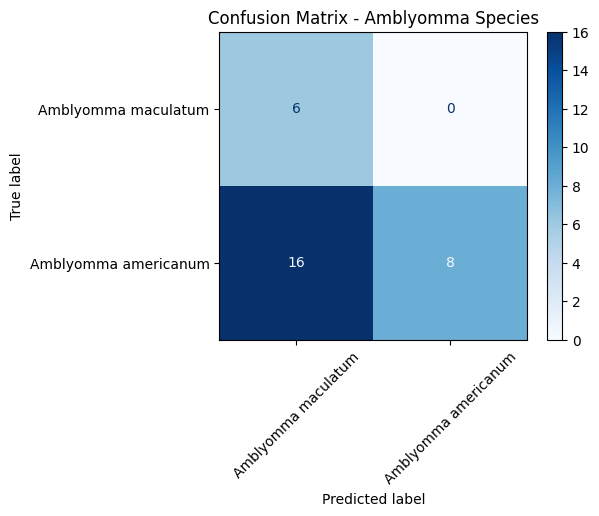

Amblyomma Confusion Matrix (raw counts):
[[ 6  0]
 [16  8]]


In [ ]:
# Creating Separate 2x2 Matrices for Amblyomma maculatum vs Amblyomma americanum
# Define the labels for Amblyomma species
amb_labels = ["Amblyomma maculatum", "Amblyomma americanum"]

# Filter y_true and y_pred to only include Amblyomma samples
amb_true = [true for true, pred in zip(y_true, y_pred) if true in amb_labels]
amb_pred = [pred for true, pred in zip(y_true, y_pred) if true in amb_labels]

# Generate confusion matrix for Amblyomma species
cm_amb = confusion_matrix(amb_true, amb_pred, labels=amb_labels)

# Plot
disp_amb = ConfusionMatrixDisplay(confusion_matrix=cm_amb, display_labels=amb_labels)
fig, ax = plt.subplots(figsize=(5, 4))
disp_amb.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix - Amblyomma Species")
plt.show()

print("Amblyomma Confusion Matrix (raw counts):")
print(cm_amb)



In [ ]:
# # Define the labels for Ixodes species
# ix_labels = ["Ixodes", "Ixodes scapularis"]

# # Filter y_true and y_pred to only include Ixodes samples
# ix_true = [true for true, pred in zip(y_true, y_pred) if true in ix_labels]
# ix_pred = [pred for true, pred in zip(y_true, y_pred) if true in ix_labels]

# # Generate confusion matrix for Ixodes species
# cm_ix = confusion_matrix(ix_true, ix_pred, labels=ix_labels)

# # Plot
# disp_ix = ConfusionMatrixDisplay(confusion_matrix=cm_ix, display_labels=ix_labels)
# fig, ax = plt.subplots(figsize=(5, 4))
# disp_ix.plot(cmap='Blues', xticks_rotation=45, ax=ax)
# plt.title("Confusion Matrix - Ixodes Species")
# plt.show()

# print("Ixodes Confusion Matrix (raw counts):")
# print(cm_ix)
